In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_data = data_providers.EMNISTDataProvider('train', batch_size=100000)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=15800)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x109309d30>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x11b841208>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x109309d30>)


In [12]:
model_names = ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution', 'max_avg_pooling']
models = OrderedDict()
stats = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
num_filters = 128
num_layers = 4
kernel_sizes = 3
num_epochs = 50
weight_decay_coefficient = 1e-5
seed = 7112018
use_gpu = False

In [13]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [14]:
# load summary stats
for model_name in (model_names):
    experiment_log_dir = './outputs/downsample/' + model_name + '/result_outputs/'
    summary = load_statistics(experiment_log_dir, 'summary.csv')
    stats[model_name] = summary

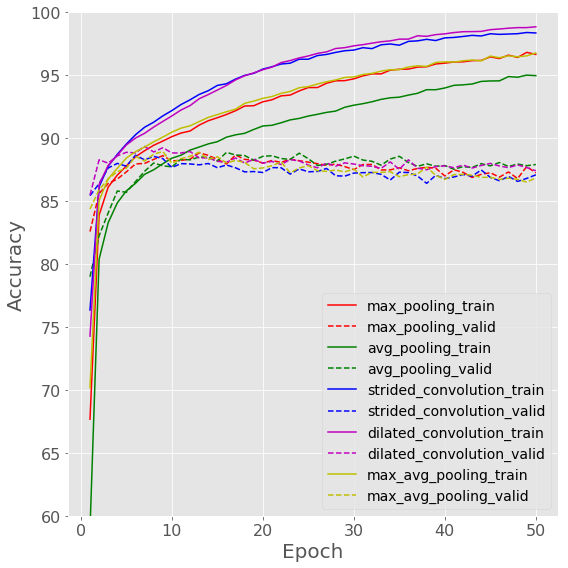

In [26]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm', 'y']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float') * 100, label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float') * 100, label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=4, fontsize=14)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Broaden Context', fontsize=20)
plt.savefig('./plots/2_2_reduction.pdf')
# 

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

best_idxs = []
best_valid_accs = []
best_train_accs = []
num_params = []
# load best models
for model_name in model_names:
    print(model_name)
    conv_model = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=model_name,
        num_output_classes=47, 
        num_filters=num_filters, 
        num_layers=num_layers, 
        kernel_size=3,
        use_bias=True)
    
    model_save_dir = './outputs/downsample/' + model_name + '/saved_models/'
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", 49))
    
    device = torch.device('cpu')
    state = torch.load(path, map_location=device)
    best_val_model_idx, best_val_model_acc = state['best_val_model_idx'], state['best_val_model_acc']
    best_idxs.append(best_val_model_idx)
    
    best_valid_accs.append(best_val_model_acc)
    best_train_acc = stats[model_name]['train_acc'][best_val_model_idx]
    best_train_accs.append(best_train_acc)
    
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", best_val_model_idx))
    state = torch.load(path, map_location=device)
    new_state = rename_dict_key(state['network'])
    conv_model.load_state_dict(state_dict=new_state)
    conv_model.eval()
    
    models[model_name] = conv_model
    num = count_parameters(conv_model)
    num_params.append(num)

max_pooling
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 3, 3])
shape before final linear layer torch.Size([128, 128, 2, 2])
Block is built, output volume is torch.Size([128, 47])
avg_pooling
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 3, 3])
shape before final linear layer torch.Size([128, 128, 2, 2])
Block is built, output volume is torch.Size([128, 47])
strided_convolution
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Si

In [22]:
num_params

[468143, 468143, 1058479, 1058479, 468143]

In [24]:
best_train_accs

['0.910431338028169',
 '0.900848271446863',
 '0.9027688860435339',
 '0.9039092509603073',
 '0.9009082906530089']

In [25]:
best_valid_accs

[0.8884654471544715,
 0.8887830284552846,
 0.8865599593495935,
 0.893483231707317,
 0.8894817073170732]